In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import os.path as op
from tqdm.notebook import tqdm
#pip install --upgrade google-api-python-client
#pip install --upgrade google-auth-oauthlib google-auth-httplib2

sys.path.insert(0, '..') # project folder
path_data = op.join('..', 'data', 'raw')
path_deriv = op.join(path_data, '..', 'derivatives')
path_metadata = op.join(path_data, "yt_metadata_en.jsonl.gz")
path_edu = op.join(path_deriv, "Education_videos_{}.csv")

API_KEY = pd.read_json(op.join('.','config.json'))['api_key'][0]

In [8]:
def extract_channels_edu(verbose = False):
    channels = []
    for i in range(8):
            if verbose :
                print(f'Processing file : path_edu_{i}', end = '')
            edu = pd.read_csv(path_edu.format(i), index_col=0)
            ch = list(pd.unique(edu['channel_id']))
            if verbose : 
                print(f"  --> Found {len(ch)} channels")
            channels.extend(ch)
    channels = list(set(channels))
    if verbose:
         print('Total number of channels :' , len(channels))
    return channels

channels = extract_channels_edu(verbose = True)

Processing file : path_edu_0  --> Found 3412 channels
Processing file : path_edu_1  --> Found 3039 channels
Processing file : path_edu_2  --> Found 3069 channels
Processing file : path_edu_3  --> Found 3036 channels
Processing file : path_edu_4  --> Found 3384 channels
Processing file : path_edu_5  --> Found 3282 channels
Processing file : path_edu_6  --> Found 3150 channels
Processing file : path_edu_7  --> Found 3224 channels
Total number of channels : 25587


In [ ]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

def youtube_country_scraper(api_key, channel_ids, verbose = False):
    # Disable OAuthlib's HTTPS verification when running locally. *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    youtube = build('youtube', 'v3', developerKey = api_key)
    ids_string = ",".join(channel_ids)
    
    request = youtube.channels().list(
        part = 'snippet',
        id= ids_string
    )
    items = request.execute()
    countries = {ch: 'Redo' for ch in channel_ids}
    if ('items' in items): # for when you redo with single channels
        for item in items.get('items', []):
            if 'snippet' in item:
                id = item.get('id')
                country  = item.get('snippet').get('country')
                if (id in channel_ids): # else the channel now has a different id and need to be redone
                    countries[id] = country
            else:
                countries[id] = None
    else:
        countries[list(countries)[0]] = 'deleted' # channel info is not available anymore
    if verbose :
        print(items)
        print(countries)
    return countries

In [ ]:
countries = pd.DataFrame(columns = ['channel_id', 'country']) 
countries['channel_id'] = channels
countries['country'] = 'empty'

In [9]:
if op.isfile(op.join(path_deriv, 'countries.csv')):
    countries = pd.read_csv(op.join(path_deriv, 'countries.csv'), index_col = 0)

In [ ]:
start = 0
end = len(countries) # max 10k per day - improved since now we do batches so can run all of them in one go
batch_size = 50 # max youtube allows per request

try:
    for i in tqdm(range(start,end,batch_size), total = (end - start)//batch_size, desc = 'Country extraction'):
        chs = channels[i:min(i+batch_size,end)]
        nations = youtube_country_scraper(API_KEY, chs, verbose= False)
        
        for ch in chs:
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

    if end % batch_size != 0:
        chs_extra = channels[(end//batch_size)* batch_size:end]
        nations = youtube_country_scraper(API_KEY, chs_extra, verbose= False)
        for i, ch in enumerate(chs_extra):
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

except HttpError as e:
        if e.resp.status == 403:
            print('Quota exceeded, saving extracted countries')
            countries.to_csv(op.join(path_deriv, 'countries.csv'), index = False)        

countries.to_csv(op.join(path_deriv, 'countries.csv'))
tqdm.write('Done!                                        ')

In [ ]:
#?????
#countries.loc[countries.country == 'deleted', 'country'] = 'Redo'
#Redo those that did not return the same channel id
countries_redo = countries[countries.country == 'deleted'].reset_index(drop = True) 
for i, ch in tqdm(enumerate(countries_redo.channel_id), total = len(countries_redo)//10, desc = 'Countries redo'):
    nations = youtube_country_scraper(API_KEY, [ch], verbose= False)
    countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
    tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

countries.to_csv(op.join(path_deriv, 'countries.csv'))

In [ ]:
pd.set_option("display.max_rows", None) #11 is default
display(countries.country.value_counts(dropna=True))

# Countplot of countries

In [109]:
#group in single category all the countries with less than 10 channels
filter = 20
to_plot = countries.copy()
value_countss = to_plot['country'].value_counts()
to_plot['country'] = to_plot['country'].apply(lambda x: 'Other' if type(x) == str and value_countss[x] < filter  else x)

to_plot.country.value_counts(dropna=False)
to_plot[to_plot.country == 'deleted'] = '?'
to_plot.country  = to_plot.country.fillna('?')

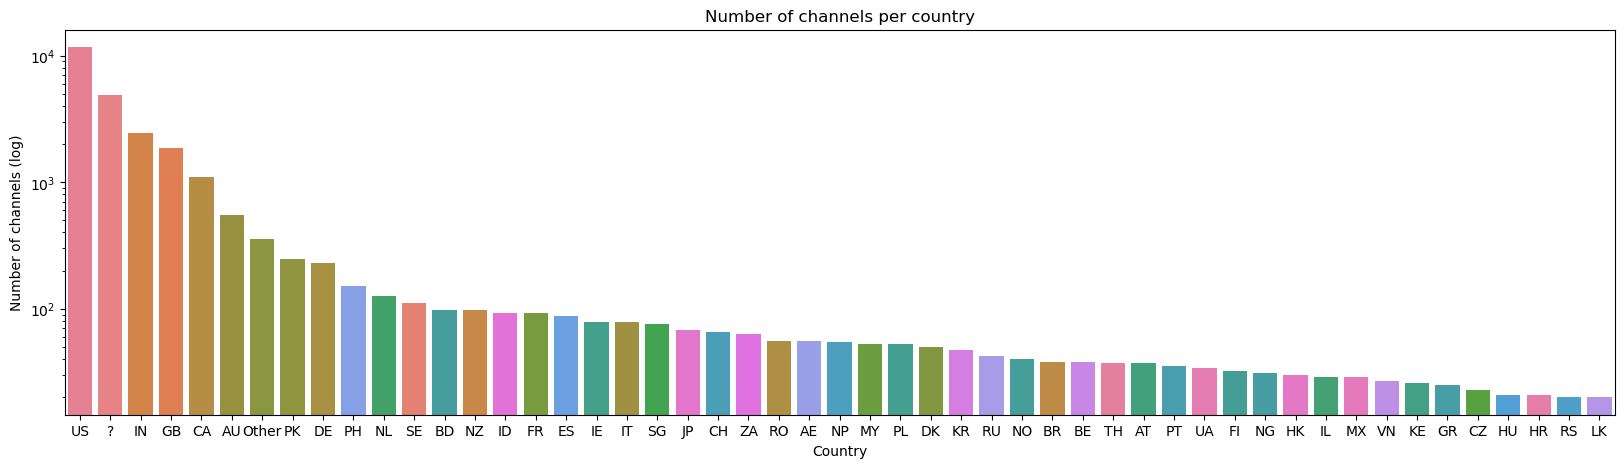

In [110]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x='country', data=to_plot, order = to_plot['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_yscale('log')
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
plt.show()
# ax.legend_.remove()

In [243]:
countries.to_csv(op.join(path_deriv, 'countries.csv'))

## other explored methods - legacy 

In [ ]:
#import requests as req
#from bs4 import BeautifulSoup as bs
"""url = r'https://socialblade.com/youtube/c/simonegiertz'
r = req.get(url)
print('Response status code: {0}\n'.format(r.status_code))
soup = bs(r.text, 'html.parser')
country = soup.find('span', {'id': 'youtube-stats-header-country'}).text
print(country)"""

In [ ]:
#Web archive for Socialblade - solution not practical
"""url = r'https://web.archive.org/web/20161218062757/https://socialblade.com/youtube/user/leafyishere/monthly'
r = req.get(url)
print('Response status code: {0}\n'.format(r.status_code))
soup = bs(r.text, 'html.parser')
country = soup.find('span', {'id': 'youtube-stats-header-country'}).text
print(country)"""

Response status code: 200

US
